## Thing to do

```bash
(1) CNN Construct
(last) Visualize x_hat with 8X8 comparing with x and x_hat
```

## 2022S Student Project: Deep Supervised Learning for MRI Reconstruction

### [0]Necessary Module
```bash
conda install h5py       : dataset compatibility
conda install tqdm       : Track the training process
pip install scikit-image : Compute PSNR and SSIM
```

In [64]:
import numpy as np
import h5py

In [65]:
with h5py.File('C:/Users/pyiph/Desktop/CIG Project/dataset.hdf5', 'r') as hdf:
    ls = list(hdf.keys())
    # Check the dataset structure
    print('List of datasets in this file: \n', ls)
    
    # Get ground-truth(trnOrg)
    x = hdf.get('trnOrg')
    # Get Sampling operator(trnMask)
    p = hdf.get('trnMask')
    
    # Test ground-truth
    tX = hdf.get('tstOrg')
    # Test Sampling operator
    tP = hdf.get('tstMask')
    
    '''Get the corresponding array
    xArray.shape: (360, 256, 232)
    pArray.shape: (360, 256, 232)
    '''
    xArray = np.abs(np.array(x))
    
    pArray = np.array(p)
    
    tXArray = np.abs(np.array(tX))
    tPArray = np.array(tP)

List of datasets in this file: 
 ['trnCsm', 'trnMask', 'trnOrg', 'tstCsm', 'tstMask', 'tstOrg']


### [1] Obtain y and x_hat 



P: `Sampling operator` (pArray)

F: `Fourier transform`

e: in this project we will `set it as zero`



In [66]:
def cal_fft(img, mask):
    f = np.fft.fft2(img)*mask
    #fshift = np.fft.fftshift(f)
    return f

def cal_ifft(fshift):
    #f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(fshift)
    img_back = np.abs(img_back)
    
    return img_back

In [67]:
import numpy as np
from matplotlib import pyplot as plt

# initialize yArray / xHat
yArray = cal_fft(xArray, pArray)
xHat = cal_ifft(yArray)

# Testset operation
tYArray = (cal_fft(tXArray, tPArray))
tXHat = cal_ifft(tYArray)

xArray = xArray.astype('float')
xHat = xHat.astype('float')

visualXArray = xArray.astype('float')
visualXHat = xHat.astype('float')

Text(0.5, 1.0, 'X Hat')

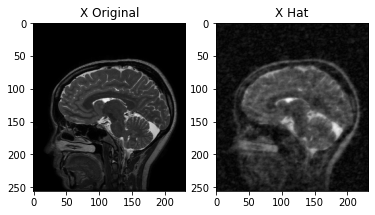

In [68]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(visualXArray[8], cmap='gray')

ax.set_title('X Original')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(visualXHat[8], cmap='gray')
ax.set_title('X Hat')

## [3] Model Training

### [3-1] Data split (Train / Validation / Test)

In [69]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

xHat = torch.from_numpy(xHat)
xArray = torch.from_numpy(xArray)

tXHat = torch.from_numpy(tXHat)
tXArray = torch.from_numpy(tXArray)

# Train/Validation/Test: 69% / 20%/ 11%
data_val, data_test, labels_val, labels_test = train_test_split(tXHat, tXArray, test_size=0.36, random_state=42)

trainDataset = TensorDataset(xHat, xArray)
valDataset = TensorDataset(data_val, labels_val)
testDataset = TensorDataset(data_test, labels_test)

trainDataLoader = DataLoader(trainDataset, batch_size=18, shuffle = True)
valDataLoader = DataLoader(valDataset, batch_size=1, shuffle = True)
testDataLoader = DataLoader(testDataset, batch_size=1, shuffle = False)

### [3-2] CNN(Convolutional Neural Network)

Input: xHat

Output: xArray


```bash


```

<!--

##### Reference Paper: RARE: Image Reconstruction using Deep Priors Learned without Groundtruth

![20220617_222458.png](attachment:20220617_222458.png)

![20220617_222201.png](attachment:20220617_222201.png)
-->

### [3-3] CNN - Residual Structure

In [70]:
import torch.nn as nn
import torch.nn.functional as F

kernel_size = 3

class DnCNN(torch.nn.Module):
    class Block(torch.nn.Module):
        def __init__(self, n_input, n_output, stride=1):
            super().__init__()
            self.net = torch.nn.Sequential(
            torch.nn.Conv2d(n_input, n_output, kernel_size = kernel_size, padding = (int) (kernel_size / 2), stride = stride, bias = False),
            torch.nn.BatchNorm2d(n_output),
            torch.nn.ReLU(),
            torch.nn.Conv2d(n_output, n_output, kernel_size = kernel_size, padding = (int) (kernel_size / 2), bias = False),
            torch.nn.BatchNorm2d(n_output),
            torch.nn.ReLU()
            )
            self.downsample = None
            if stride != 1 or n_input != n_output:
                self.downsample = torch.nn.Sequential(torch.nn.Conv2d(n_input, n_output, kernel_size = kernel_size, padding = (int) (kernel_size / 2), stride = stride, bias = False),
                                                      torch.nn.BatchNorm2d(n_output))
        def forward(self, x):
            identity = x
            if self.downsample is not None:
                identity = self.downsample(x)
            return self.net(x) + identity
    
    def __init__(self, channels=1):
        super().__init__()
        features = 64
        L = [torch.nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=7, padding=(int) (7 / 2), bias=False),
             torch.nn.BatchNorm2d(features),
             torch.nn.ReLU(),
             torch.nn.Conv2d(in_channels=features, out_channels=features, kernel_size=7, padding=(int) (7 / 2), bias=False),
             torch.nn.BatchNorm2d(features),
             torch.nn.ReLU()
            ]
        numberOfResBlock = 3
        
        for l in range(numberOfResBlock):
            L.append(self.Block(features, features))
         
        L.append(torch.nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=(int) (kernel_size / 2)))
        self.network = torch.nn.Sequential(*L)
         
    def forward(self, x):
        out = self.network(x)
        out = torch.abs(out)
        return out

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Check the GPU Availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [72]:
# To refresh gpu cache
import gc
gc.collect()
torch.cuda.empty_cache()

### [3-4] Deep Neural Network Model - Training

In [92]:
# Initial training
#model = DnCNN().to(device)
# Pre-trained model training
#model = torch.load("C:/Users/pyiph/Desktop/CIG Project/model/model10")
model = torch.load("C:/Users/pyiph/Desktop/CIG Project/model/Best_improved_model2")

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.03, step_size_up = 60, cycle_momentum=False)

epochs = 240

for epoch in range(epochs):
    model.train()
    lossTrain = []
    lossVal = []
    for ii, (data, label) in enumerate(trainDataLoader):
        data, label = data.to(device).float(), label.to(device).float()

        # Reshape the datasize
        data = data.view(-1, 1, xArray.shape[1], xArray.shape[2])
        label = label.view(-1, 1, xArray.shape[1], xArray.shape[2])

        # Produce model output
        output = model(data)

        # compute the loss and accuracy
        loss = loss_function(output, label)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cnn_output = np.squeeze(output.cpu().detach().numpy())

        lossTrain.append(loss.item())

    with torch.no_grad():
        model.eval()
        for vii, (vData, vLabel) in enumerate(valDataLoader):
            vData, vLabel = vData.to(device).float(), vLabel.to(device).float()
            # Reshape the datasize
            vData = vData.view(-1, 1, xArray.shape[1], xArray.shape[2])
            vLabel = vLabel.view(-1, 1, xArray.shape[1], xArray.shape[2])

            val_output = model(vData)
            val_loss = loss_function(val_output, vLabel)
            lossVal.append(val_loss.item())

    # print avg training statistics 
    avgTrainLoss = sum(lossTrain)/len(lossTrain)
    avgValLoss = sum(lossVal)/len(lossVal)
    
    scheduler.step(avgValLoss)
    if epoch % 10 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            avgTrainLoss,
            avgValLoss
            ))

Epoch: 0 	Training Loss: 0.022965 	Validation Loss: 0.015413
Epoch: 10 	Training Loss: 0.002531 	Validation Loss: 0.002394
Epoch: 20 	Training Loss: 0.002882 	Validation Loss: 0.002301
Epoch: 30 	Training Loss: 0.002428 	Validation Loss: 0.002467
Epoch: 40 	Training Loss: 0.002484 	Validation Loss: 0.002609
Epoch: 50 	Training Loss: 0.002764 	Validation Loss: 0.001975
Epoch: 60 	Training Loss: 0.002353 	Validation Loss: 0.001893
Epoch: 70 	Training Loss: 0.002221 	Validation Loss: 0.002008
Epoch: 80 	Training Loss: 0.002174 	Validation Loss: 0.002334
Epoch: 90 	Training Loss: 0.002202 	Validation Loss: 0.002031
Epoch: 100 	Training Loss: 0.002233 	Validation Loss: 0.002531
Epoch: 110 	Training Loss: 0.002479 	Validation Loss: 0.001877
Epoch: 120 	Training Loss: 0.002105 	Validation Loss: 0.002121
Epoch: 130 	Training Loss: 0.002134 	Validation Loss: 0.001775
Epoch: 140 	Training Loss: 0.002095 	Validation Loss: 0.002017
Epoch: 150 	Training Loss: 0.002092 	Validation Loss: 0.002286
Epo

### [3-5] Deep Neural Network Model - Model Saving

In [93]:
rootDirectory = "C:/Users/pyiph/Desktop/CIG Project/model/"

torch.save(model, rootDirectory + "Best_improved_model3")

## [4] Output of testset

### [4-1] Evaluation of PSNR and SSIM

<!--
https://pythonmana.com/2021/08/20210810150803572p.html
-->

In [94]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [95]:
# Module to estimate PSNR and SSIM
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

model.eval()
#print(model.training)

with torch.no_grad():
    model.eval()
    psnrLossList = []
    ssimLossList = []
    for tii, (tData, tLabel) in enumerate(testDataLoader):
        tData, tLabel = tData.to(device).float(), tLabel.to(device).float()
        # Reshape the datasize
        tData = tData.view(-1, 1, xArray.shape[1], xArray.shape[2])
        tLabel = tLabel.view(-1, 1, xArray.shape[1], xArray.shape[2])
        test_output = model(tData)
        
        # Convert to numpy
        test_output = test_output.cpu().numpy()
        tLabel = tLabel.cpu().numpy()
        
        # Normalize array
        test_output = NormalizeData(test_output)
        tLabel = NormalizeData(tLabel)
        
        psnr_loss = psnr(test_output[0][0], tLabel[0][0])
        ssim_loss = ssim(test_output[0][0], tLabel[0][0], multichannel=True)

        psnrLossList.append(psnr_loss)
        ssimLossList.append(ssim_loss)

    # print avg training statistics 
    avgPsnrLoss = sum(psnrLossList)/len(psnrLossList)
    avgSsimLoss = sum(ssimLossList)/len(ssimLossList)

print(f"Average PSNR Loss: {avgPsnrLoss}")
print(f"Average SSIM Loss: {avgSsimLoss}")

C:\Users\pyiph\AppData\Local\Temp/ipykernel_20324/2454977286.py:29: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_loss = ssim(test_output[0][0], tLabel[0][0], multichannel=True)


Average PSNR Loss: 30.006320666329138
Average SSIM Loss: 0.8117418582240741


### [4-2] Visualizing test result

C:\Users\pyiph\AppData\Local\Temp/ipykernel_20324/4055763506.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


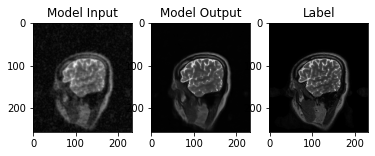

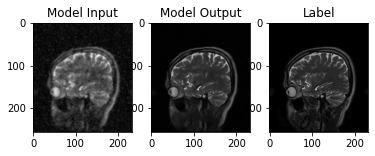

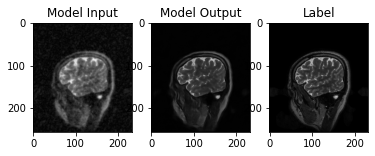

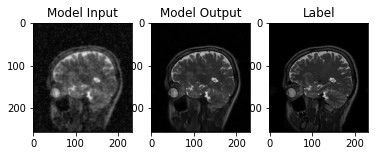

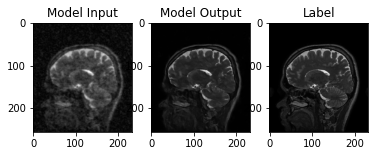

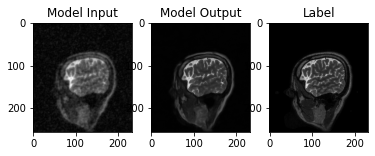

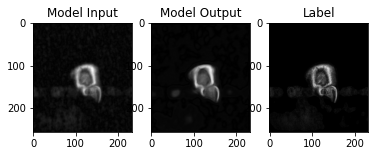

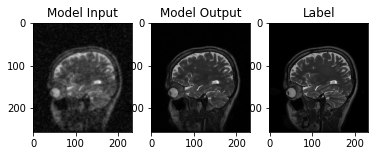

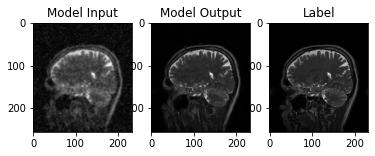

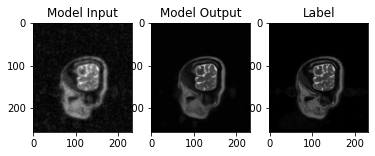

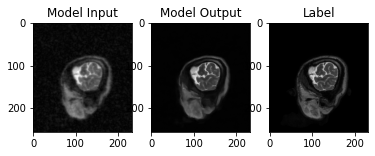

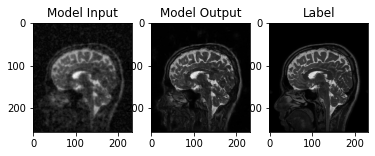

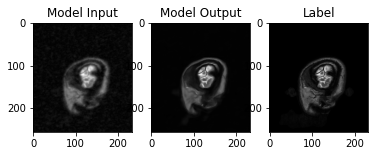

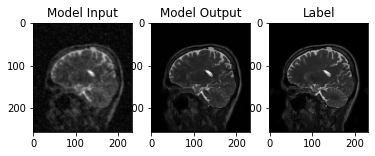

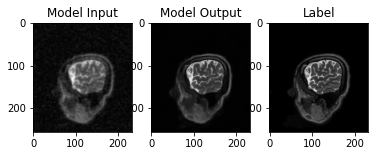

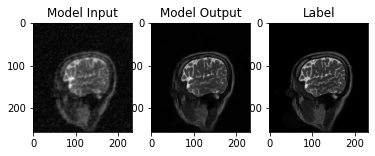

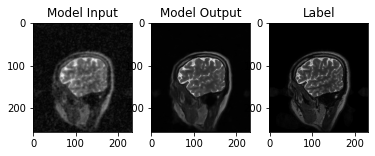

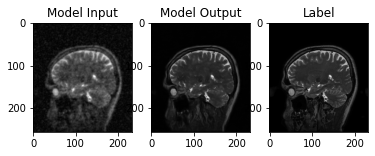

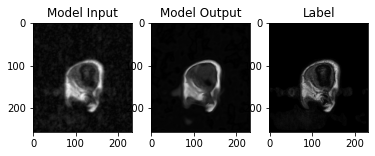

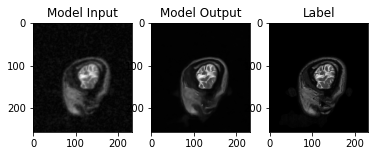

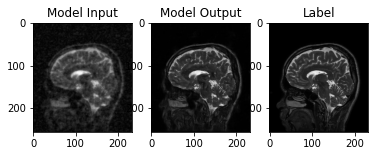

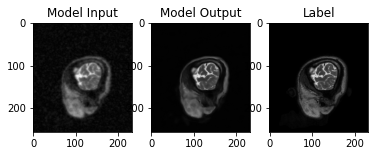

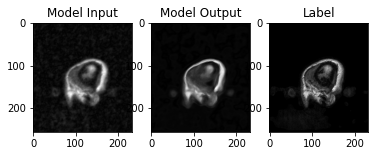

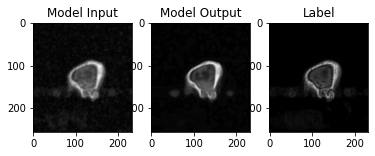

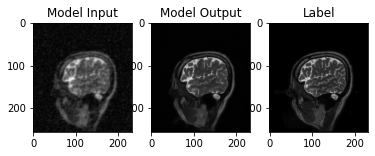

In [96]:
# Input : tXHat
# Output: Model(tXHat)
with torch.no_grad():
    model.eval()
    i = 0
    for tii, (tData, tLabel) in enumerate(testDataLoader):
        tData, tLabel = tData.to(device).float(), tLabel.to(device).float()
        # Reshape the datasize
        tData = tData.view(-1, 1, xArray.shape[1], xArray.shape[2])
        tLabel = tLabel.view(-1, 1, xArray.shape[1], xArray.shape[2])

        test_output = model(tData)

        fig = plt.figure()
        ax = fig.add_subplot(1, 3, 1)
        imgplot = plt.imshow(tData[0][0].cpu(), cmap='gray')
        ax.set_title('Model Input')
        ax = fig.add_subplot(1, 3, 2)
        imgplot = plt.imshow(np.abs(test_output[0][0].cpu().numpy()), cmap='gray')
        ax.set_title('Model Output')
        ax = fig.add_subplot(1, 3, 3)
        imgplot = plt.imshow(tLabel[0][0].cpu(), cmap='gray')
        ax.set_title('Label')
        
        i += 1
        
        if i == 25:
            break